In [ ]:
from google.colab import files
files.upload()
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content"
!pip install kaggle
!kaggle datasets download -d faizalkarim/flood-area-segmentation
import zipfile
with zipfile.ZipFile('/content/flood-area-segmentation.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/flood-area-segmentation')

Saving kaggle.json to kaggle (1).json
Dataset URL: https://www.kaggle.com/datasets/faizalkarim/flood-area-segmentation
License(s): CC0-1.0
flood-area-segmentation.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
import os
#Veri yolları
input_dir = "/content/flood-area-segmentation/Image"
target_dir = "/content/flood-area-segmentation/Mask"

input_img_paths = sorted(
    [os.path.join(input_dir, fname)
     for fname in os.listdir(input_dir)
     if fname.endswith(".jpg")]
)

target_paths = sorted(
    [os.path.join(target_dir, fname)
     for fname in os.listdir(target_dir)
     if fname.endswith(".png") and not fname.startswith(".")]
)


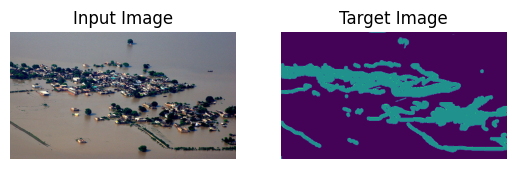

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img, img_to_array

#9. resmi ve maskesini ekrana bastırır
plt.subplot(1, 2, 1)
plt.axis("off")
plt.title("Input Image")
plt.imshow(load_img(input_img_paths[9]))

def display_target(target_array):
    normalized_array = (target_array.astype("uint8") - 1) * 127
    plt.axis("off")
    plt.imshow(normalized_array[:, :, 0])

plt.subplot(1, 2, 2)
img = img_to_array(load_img(target_paths[9], color_mode="grayscale"))
plt.title("Target Image")
display_target(img)

plt.show()


In [ ]:
import numpy as np
import random

# Tüm resimler 128x128 olarak ayarlanır
img_size = (128, 128)
num_imgs = len(input_img_paths)
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_paths)

# Giriş resimlerini işlemek için fonksiyon
def path_to_input_image(path):
    return img_to_array(load_img(path, target_size=img_size))

# maskeleri işlemek için fonksiyon
def path_to_target(path):
    img = img_to_array(
        load_img(path, target_size=img_size, color_mode="grayscale")
    )
    img = (img > 0).astype("uint8")  # 1'ler nesne 0'lar background
    return img

input_imgs = np.zeros((num_imgs,) + img_size + (3,), dtype="float32")
targets = np.zeros((num_imgs,) + img_size + (1,), dtype="uint8")

# resim ve maskeleri diziye çevirme
for i in range(num_imgs):
    input_imgs[i] = path_to_input_image(input_img_paths[i])
    targets[i] = path_to_target(target_paths[i])

# Test-Train-Validasyon Datalarını Ayırma
train_input_imgs = input_imgs[:260]  # İlk 260 veri eğitim için
train_targets = targets[:260]

val_input_imgs = input_imgs[260:275]  # Sonraki 15 veri doğrulama için
val_targets = targets[260:275]

test_input_imgs = input_imgs[275:]  # Son 15 veri test için
test_targets = targets[275:]



In [ ]:
from tensorflow.keras import layers, Model

def get_model(img_size=(128, 128), num_classes=1):
    inputs = layers.Input(shape=img_size + (3,))

    x = layers.Rescaling(1.0 / 255)(inputs)

    # Encoder
    x = layers.Conv2D(64, 3, strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(128, 3, strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2D(128, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(256, 3, strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2D(256, 3, activation="relu", padding="same")(x)

    # Decoder
    x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same", strides=2)(x)
    x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same", strides=2)(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same", strides=2)(x)

    # Çıkış Katmanı
    outputs = layers.Conv2D(num_classes, 1, activation="sigmoid", padding="same")(x)

    model = Model(inputs, outputs)
    return model

model1 = get_model(img_size=(128, 128), num_classes=1)
model1.summary()


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_7 (Rescaling)              │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_80 (Conv2D)                   │ (None, 64, 64, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_81 (Conv2D)                   │ (None, 64, 64, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_82 (Conv2D)                   │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_83 (Conv2D)                   │ (None, 32, 32, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_84 (Conv2D)                   │ (None, 16, 16, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_85 (Conv2D)                   │ (None, 16, 16, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_32                  │ (None, 16, 16, 256)         │         590,080 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_33                  │ (None, 32, 32, 256)         │         590,080 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_34                  │ (None, 32, 32, 128)         │         295,040 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_35                  │ (None, 64, 64, 128)         │         147,584 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_36                  │ (None, 64, 64, 64)          │          73,792 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_37                  │ (None, 128, 128, 64)        │          36,928 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_86 (Conv2D)                   │ (None, 128, 128, 1)         │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,878,977 (10.98 MB)

 Trainable params: 2,878,977 (10.98 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model1.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

Epoch 1/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 390ms/step - accuracy: 0.5407 - loss: 0.6915 - val_accuracy: 0.4997 - val_loss: 0.6978
Epoch 2/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - accuracy: 0.6047 - loss: 0.6797 - val_accuracy: 0.4997 - val_loss: 0.6957
Epoch 3/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - accuracy: 0.6008 - loss: 0.6754 - val_accuracy: 0.5038 - val_loss: 0.6796
Epoch 4/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accuracy: 0.6138 - loss: 0.6396 - val_accuracy: 0.7021 - val_loss: 0.6125
Epoch 5/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accuracy: 0.7188 - loss: 0.5710 - val_accuracy: 0.7607 - val_loss: 0.5629
Epoch 6/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accuracy: 0.7662 - loss: 0.5175 - val_accuracy: 0.7912 - val_loss: 0.4517
Epoch 7/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accuracy: 0.7742 - loss: 0.5090 - val_accuracy: 0.8177 - val_loss: 0.4169
Epoch 8/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - accuracy: 0.7815 - loss: 0.4781 - val_accuracy: 0.8097 - val_loss: 0.4564

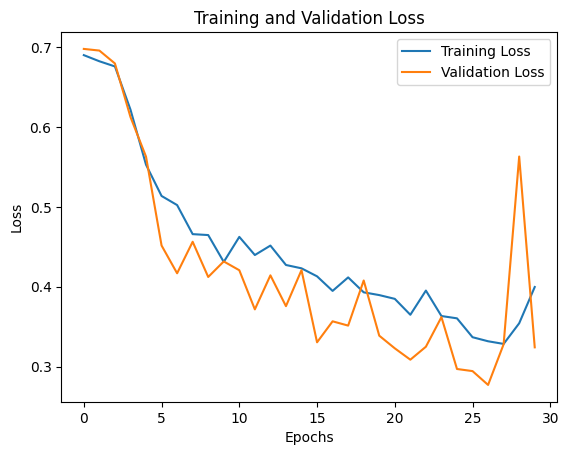

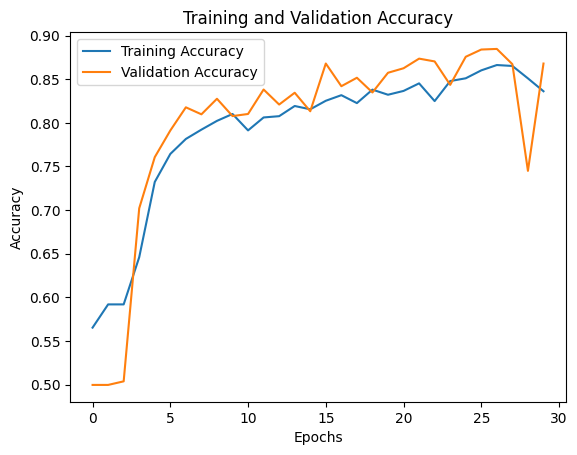

In [ ]:
history = model1.fit(
    train_input_imgs,  # Eğitim veri girdileri
    train_targets,     # Eğitim veri hedefleri
    validation_data=(val_input_imgs, val_targets),  # Doğrulama verisi
    epochs=30,         # Eğitim için toplam epoch sayısı
    batch_size=32,     # Her batch için örnek sayısı
)
import matplotlib.pyplot as plt

# Eğitim ve doğrulama kaybı (loss) grafiği
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Eğitim ve doğrulama doğruluğu (accuracy) grafiği
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()


In [ ]:
from tensorflow.keras import layers, Model

def get_model2(img_size=(128, 128), num_classes=1):
    inputs = layers.Input(shape=img_size + (3,))

    x = layers.Rescaling(1.0 / 255)(inputs)

    # Encoder
    x = layers.Conv2D(64, 3, strides=2, activation="relu", padding="same")(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Conv2D(128, 3, strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2D(128, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(256, 3, strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2D(256, 3, activation="relu", padding="same")(x)


    # Decoder
    x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same", strides=2)(x)
    x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same", strides=2)(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same", strides=2)(x)

    # Çıkış Katmanı
    outputs = layers.Conv2D(num_classes, 1, activation="sigmoid", padding="same")(x)

    model = Model(inputs, outputs)
    return model

model2 = get_model2(img_size=(128, 128), num_classes=1)
model2.summary()


Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_15 (InputLayer)          │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_15 (Rescaling)             │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_136 (Conv2D)                  │ (None, 64, 64, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_137 (Conv2D)                  │ (None, 64, 64, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_138 (Conv2D)                  │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_139 (Conv2D)                  │ (None, 32, 32, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_140 (Conv2D)                  │ (None, 16, 16, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_141 (Conv2D)                  │ (None, 16, 16, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_80                  │ (None, 16, 16, 256)         │         590,080 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_81                  │ (None, 32, 32, 256)         │         590,080 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_82                  │ (None, 32, 32, 128)         │         295,040 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_83                  │ (None, 64, 64, 128)         │         147,584 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_84                  │ (None, 64, 64, 64)          │          73,792 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_85                  │ (None, 128, 128, 64)        │          36,928 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_142 (Conv2D)                  │ (None, 128, 128, 1)         │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,878,977 (10.98 MB)

 Trainable params: 2,878,977 (10.98 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model2.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

Epoch 1/60
9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 480ms/step - accuracy: 0.5819 - loss: 0.6920 - val_accuracy: 0.4997 - val_loss: 0.6940
Epoch 2/60
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - accuracy: 0.5958 - loss: 0.6853 - val_accuracy: 0.4997 - val_loss: 0.6949
Epoch 3/60
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - accuracy: 0.5833 - loss: 0.6843 - val_accuracy: 0.4997 - val_loss: 0.6976
Epoch 4/60
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - accuracy: 0.6029 - loss: 0.6765 - val_accuracy: 0.5216 - val_loss: 0.6902
Epoch 5/60
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - accuracy: 0.5908 - loss: 0.6758 - val_accuracy: 0.4997 - val_loss: 0.6793
Epoch 6/60
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - accuracy: 0.6204 - loss: 0.6389 - val_accuracy: 0.7574 - val_loss: 0.5878
Epoch 7/60
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - accuracy: 0.7215 - loss: 0.5917 - val_accuracy: 0.7945 - val_loss: 0.5191
Epoch 8/60
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - accuracy: 0.7093 - loss: 0.5922 - val_accuracy: 0.7725 - val_loss: 0.5529

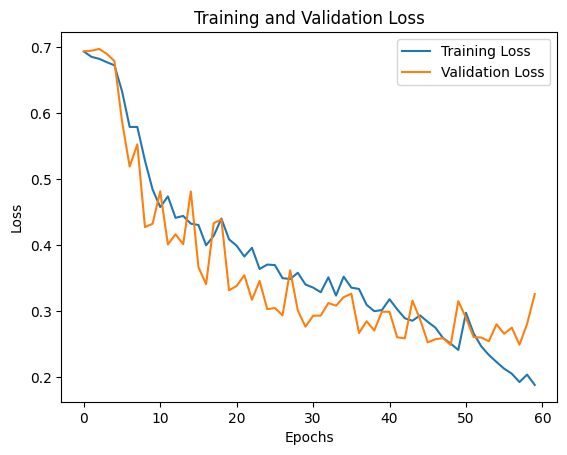

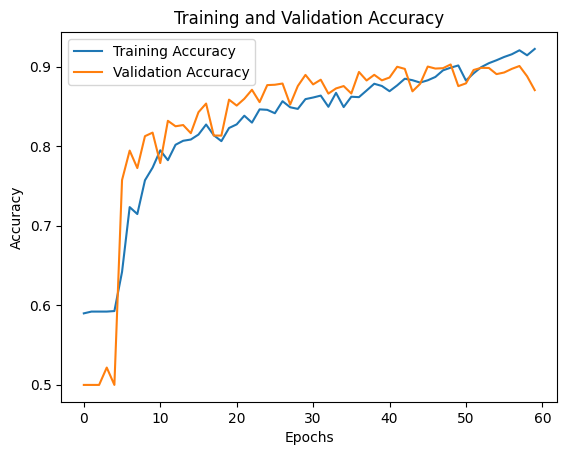

In [ ]:
history = model2.fit(
    train_input_imgs,  # Eğitim veri girdileri
    train_targets,     # Eğitim veri hedefleri
    validation_data=(val_input_imgs, val_targets),  # Doğrulama verisi
    epochs=60,         # Eğitim için toplam epoch sayısı
    batch_size=32,     # Her batch için örnek sayısı
)
import matplotlib.pyplot as plt

# Eğitim ve doğrulama kaybı (loss) grafiği
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Eğitim ve doğrulama doğruluğu (accuracy) grafiği
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()


In [ ]:
modell3 = get_model2(img_size=(128, 128), num_classes=1)
modell3.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


early_stopping = EarlyStopping(
    monitor='val_loss',  # Doğrulama kaybını izler
    patience=5,          # 5 epoch boyunca iyileşme yoksa durdur
    restore_best_weights=True  # En iyi ağırlıkları geri yükler
)

# Model kaydetme callback
model_checkpoint = ModelCheckpoint(
    'model.keras',      # Modelin kaydedileceği dosya
    monitor='val_loss',
    save_best_only=True
)

# Modeli eğit
history = modell3.fit(
    train_input_imgs, train_targets,
    validation_data=(val_input_imgs, val_targets),
    epochs=60,
    batch_size=32,
    callbacks=[early_stopping, model_checkpoint]
)


Epoch 1/60
9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 528ms/step - accuracy: 0.5731 - loss: 0.6915 - val_accuracy: 0.4997 - val_loss: 0.6941
Epoch 2/60
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - accuracy: 0.5845 - loss: 0.6847 - val_accuracy: 0.4997 - val_loss: 0.7013
Epoch 3/60
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accuracy: 0.6069 - loss: 0.6731 - val_accuracy: 0.4997 - val_loss: 0.7018
Epoch 4/60
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 0.6040 - loss: 0.6727 - val_accuracy: 0.6075 - val_loss: 0.6759
Epoch 5/60
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accuracy: 0.6657 - loss: 0.7253 - val_accuracy: 0.5027 - val_loss: 0.6767
Epoch 6/60
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accuracy: 0.5990 - loss: 0.6672 - val_accuracy: 0.4997 - val_loss: 0.7022
Epoch 7/60
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accuracy: 0.5872 - loss: 0.6780 - val_accuracy: 0.4997 - val_loss: 0.7102
Epoch 8/60
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accuracy: 0.5819 - loss: 0.6759 - val_accuracy: 0.4997 - val_loss: 0.73

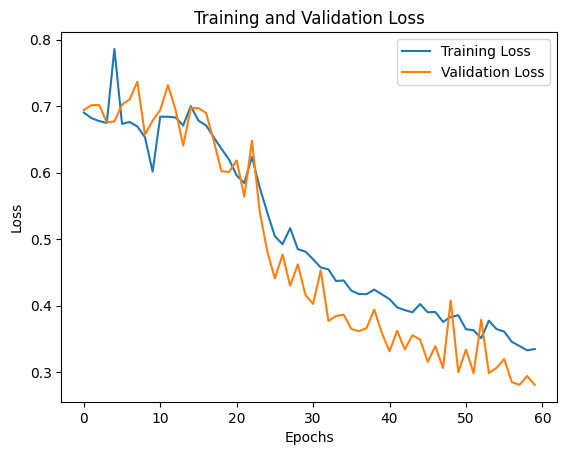

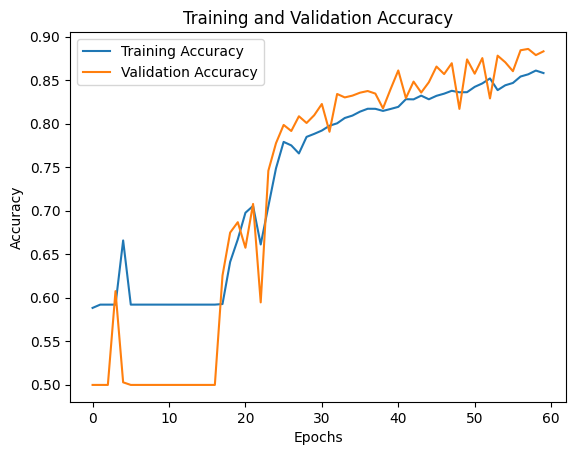

In [ ]:
# Eğitim ve doğrulama kaybı (loss) grafiği
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Eğitim ve doğrulama doğruluğu (accuracy) grafiği
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

In [ ]:
# Test verileri üzerinde modeli değerlendirir
test_loss, test_accuracy = modell3.evaluate(test_input_imgs, test_targets, verbose=1)

# Sonuçları yazdır
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.8899 - loss: 0.2884
Test Loss: 0.2884201407432556
Test Accuracy: 0.8899332880973816


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step


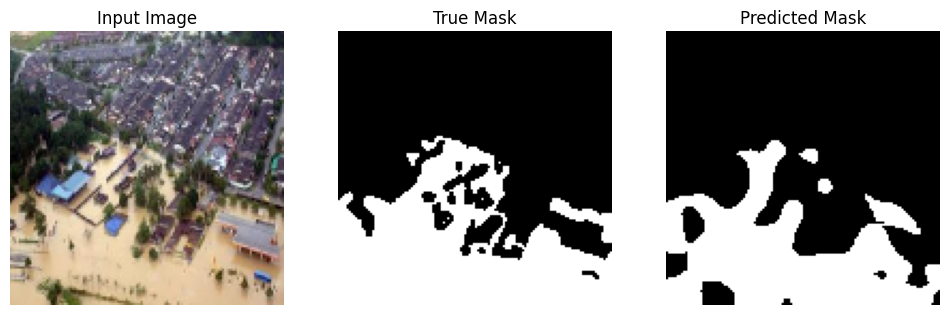

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


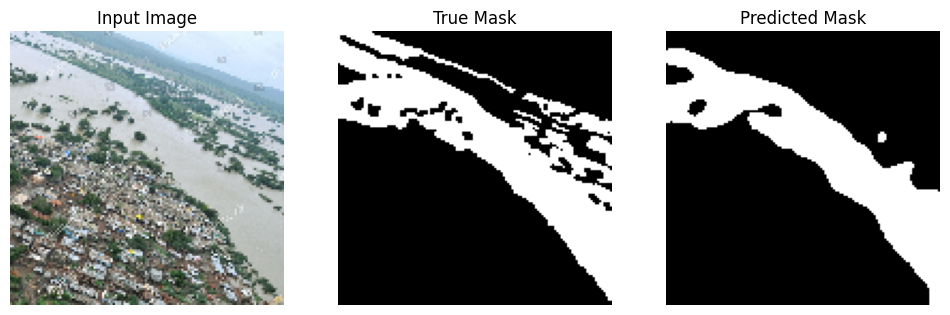

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


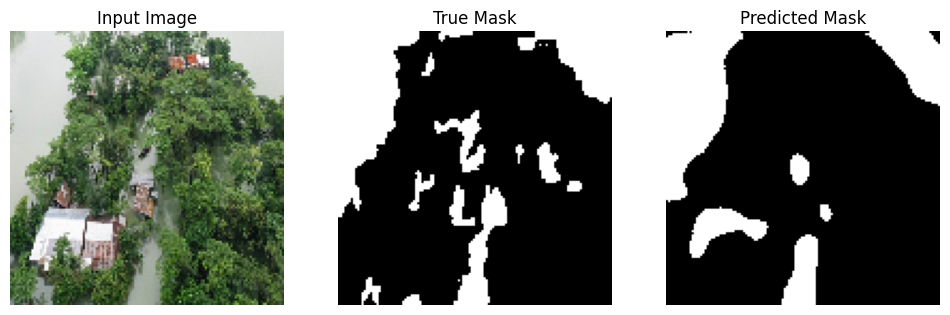

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


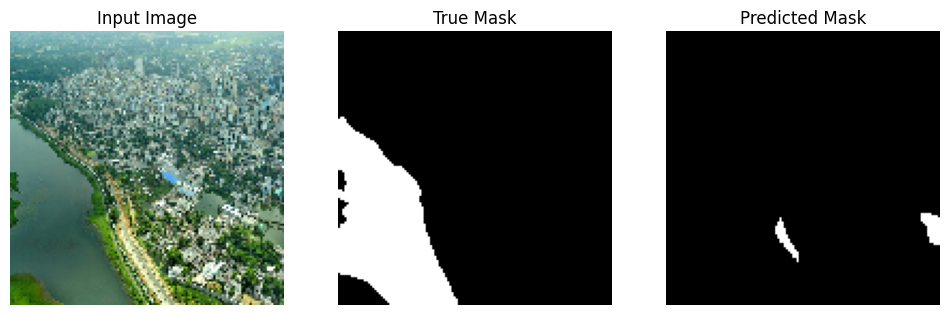

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


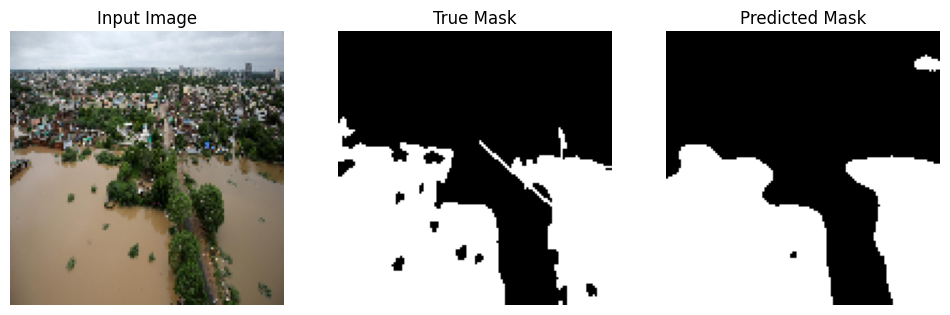

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


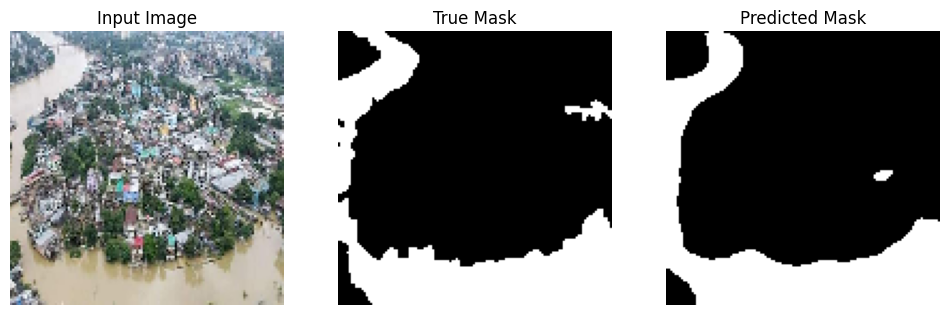

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


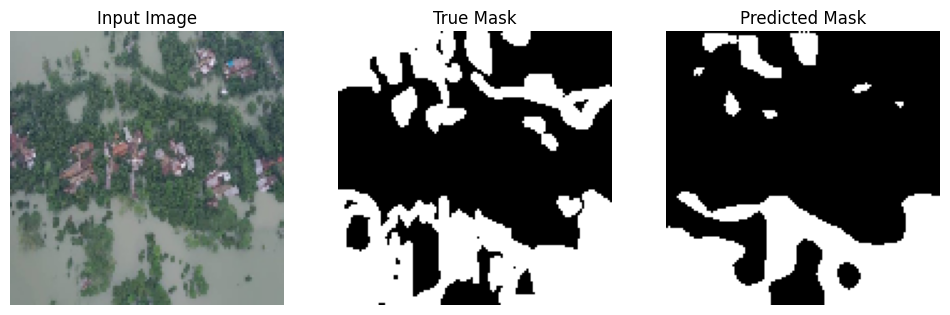

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


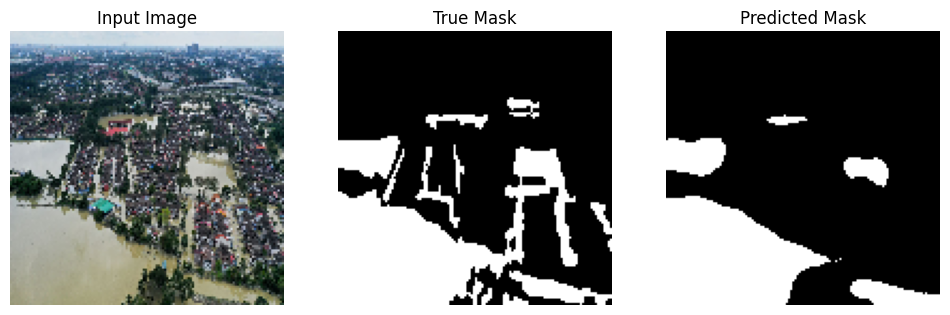

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


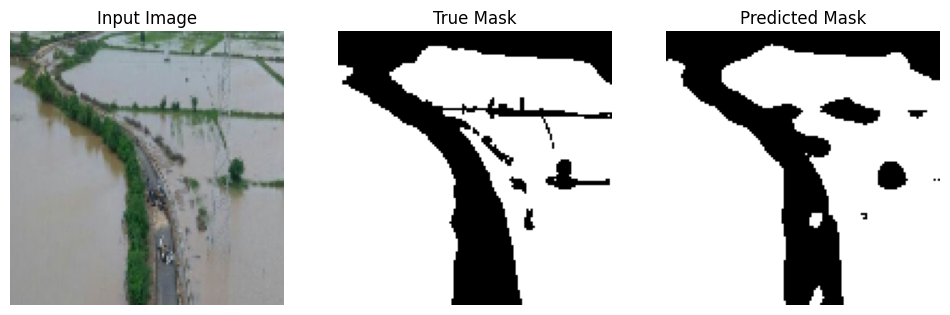

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


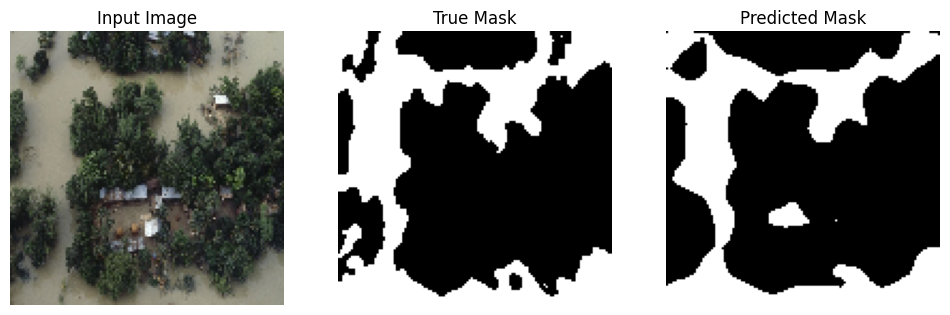

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


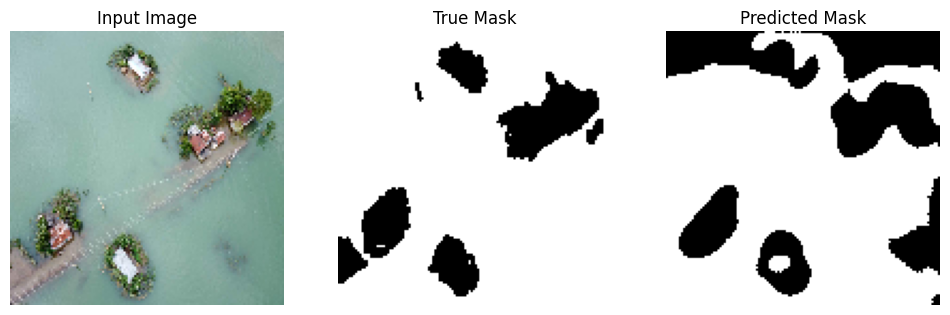

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


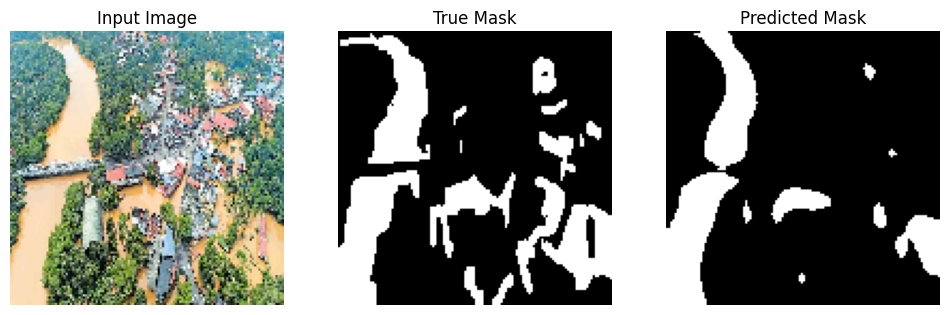

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


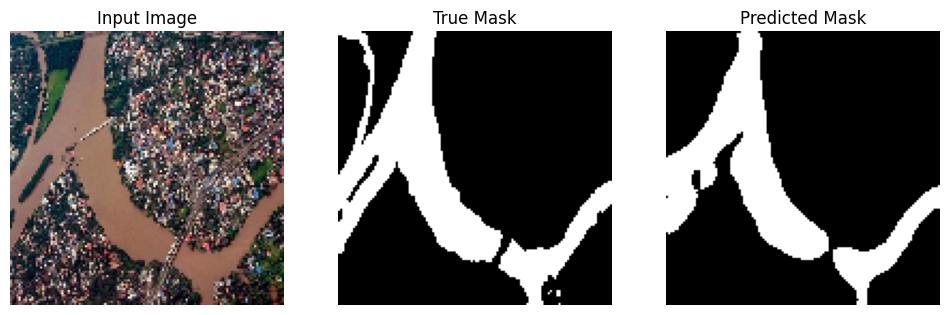

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


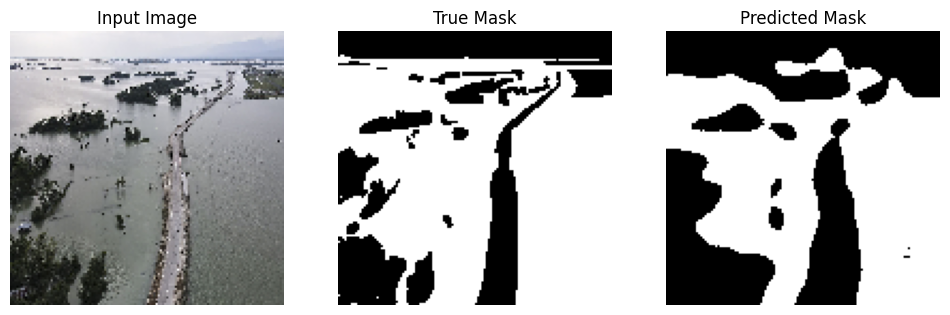

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


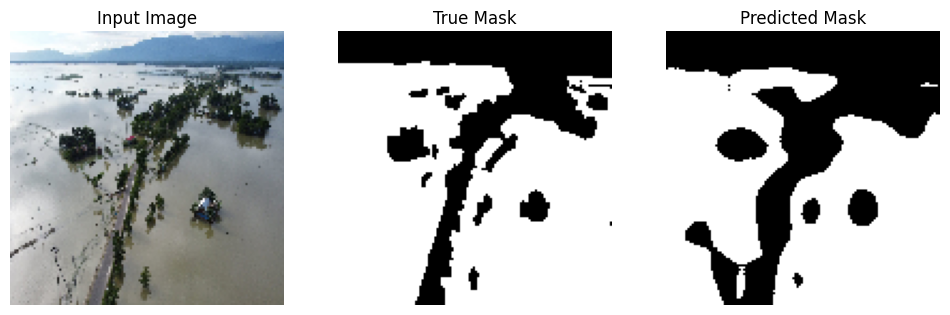

In [ ]:
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt

# Modeli yükler
model = load_model("model.keras")

# Tüm test verilerini görselleştirme
for index in range(len(test_input_imgs)):  # Test setindeki tüm görüntüler için
    test_image = test_input_imgs[index]  # Giriş görüntüsü
    true_mask = test_targets[index]  # Gerçek maske

    # Modelden tahmin al
    predicted_mask = model.predict(np.expand_dims(test_image, axis=0))
    predicted_mask = (predicted_mask > 0.5).astype(np.uint8).squeeze()

    # Görselleştirme
    plt.figure(figsize=(12, 6))

    # Test görüntüsü
    plt.subplot(1, 3, 1)
    plt.imshow(test_image.astype(np.uint8))
    plt.title("Input Image")
    plt.axis("off")

    # Gerçek maske
    plt.subplot(1, 3, 2)
    plt.imshow(true_mask.squeeze(), cmap="gray")
    plt.title("True Mask")
    plt.axis("off")

    # Tahmin edilen maske
    plt.subplot(1, 3, 3)
    plt.imshow(predicted_mask, cmap="gray")
    plt.title("Predicted Mask")
    plt.axis("off")

    plt.show()
